# CIFAR–10 Codealong

Codealong of [Radek Osmulski's notebook](https://github.com/radekosmulski/machine_learning_notebooks/blob/master/cifar10_fastai_dawnbench.ipynb) establishing a CIFAR-10 baseline with the Fastai ImageNet WideResNet22. For a [Fastai CV research collaboration](http://forums.fast.ai/t/research-collaboration-opportunity-with-leslie-smith/16454/76).

Wayne Nixalo –– 2018/6/1

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
# fastai/imagenet-fast/cifar10/models/ repo
from imagenet_fast_cifar_models.wideresnet import wrn_22
from torchvision import transforms, datasets
# allows you to enable the inbuilt cudnn auto-tuner to find the 
# best algorithm for your hardware. https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936/2
torch.backends.cudnn.benchmark = True
PATH = Path("data/cifar10")

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [4]:
## temp small dataset for fast iteration
# import cifar_utils
# PATH = cifar_utils.create_cifar_subset(PATH, copydirs=['train','test'], p=0.1)
PATH = Path("data/cifar10_tmp")

In [13]:
## Aside: making a small subset of the dataset for fast troubleshooting
## also bc idk how to marry pytorch dataloaders w/ csv's yet.
import cifar_utils
PATH = cifar_utils.create_cifar_subset(PATH, copydirs=['train','test'], p=0.1)

In [4]:
## Aside: checking the normalization transforms
tensor = T(np.ones((3,32,32)))
t1 = transforms.Normalize(stats[0], stats[1])(tensor)
t2 = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(tensor)
np.unique(np.isclose(t1, t2))

array([ True])

We construct the data object manually from low level components in a way that can be used with the fastsai library.

In [5]:
def get_loaders(bs, num_workers):
    traindir = str(PATH/'train')
    valdir   = str(PATH/'test')
    tfms     = [transforms.ToTensor(),
                transforms.Normalize(*stats)]
                #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
    aug_tfms = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
        ] + tfms)
    
    train_dataset = datasets.ImageFolder(traindir, aug_tfms)
    val_dataset   = datasets.ImageFolder(valdir, transforms.Compose(tfms))
    aug_dataset   = datasets.ImageFolder(valdir, aug_tfms)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=False)
    val_loader   = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=False)
    aug_loader   = torch.utils.data.DataLoader(
        aug_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=False)

    ## NOTE--didnt work: Want automated GPU/CPU handling so using fastai dataloaders
#     train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, 
#                               num_workers=num_workers, pin_memory=True)
#     val_loader   = DataLoader(val_dataset, batch_size=bs, shuffle=False,
#                               num_workers=num_workers, pin_memory=True)
#     aug_loader   = DataLoader(aug_dataset, batch_size=bs, shuffle=False,
#                               num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, aug_loader

This is very similar to how [Fastai initializes its `ModelData`](https://github.com/fastai/fastai/blob/HEAD/fastai/dataset.py#L301-L301), except Fastai uses the Pytorch default `pin_memory=False`.

[What is the disadvantage of using `pin_memory`?](https://discuss.pytorch.org/t/what-is-the-disadvantage-of-using-pin-memory/1702) – 
Pytorch docs:
> by pinning your batch in cpu memory, data transfer to gpu can be much faster

Soumith:
> pinned memory is page-locked memory. It's easy to shoot yourself in the foot if you enable it for everything because it can't be pre-empted. ... if you're seeing system freeze or swap being used a lot, disable it.

In [6]:
def get_data(bs, num_workers):
    trn_dl, val_dl, aug_dl = get_loaders(bs, num_workers)
    data = ModelData(PATH, trn_dl, val_dl)
    data.aug_dl = aug_dl
    data.sz = 32
    return data

def get_learner(arch, bs):
    learn = ConvLearner.from_model_data(arch.cuda(), get_data(bs, num_cpus()))
    learn.crit = nn.CrossEntropyLoss()
    learn.metrics = [accuracy]
    return learn

def get_TTA_accuracy(learn):
    preds, targs = learn.TTA()
    # combining the predictions across augmented and non augmented inputs
    preds = 0.6 * preds[0] + 0.4 * preds[1:].sum(0)
    return accuracy_np(preds, targs)

## WiP Fastai DAWN Bench submission

My copy of Radek's reimplementation of the FastAI DAWN Bench submission in terms of archutecture and training parameters – from the [imagenet-fast](https://github.com/fastai/imagenet-fast) repo.

In [ ]:
# learner = get_learner(wrn_22(), 512)
# learner.lr_find(wds=1e-4)
# learner.sched.plot(n_skip_end=1)

In [35]:
learner = get_learner(wrn_22(), 16)
learner.lr_find(wds=1e-4)
learner.sched.plot(n_skip_end=1)

> /home/ubuntu/Kaukasos/research/fastai/model.py(218)validate()
-> preds, l = stepper.evaluate(VV(x), VV(y))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(219)validate()
-> if isinstance(x,list): batch_cnts.append(len(x[0]))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(221)validate()
-> loss.append(to_np(l))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(222)validate()
-> res.append([f(preds.data, y) for f in metrics])
(Pdb) type(torch.max(preds.data, dim=1)[1])
<class 'torch.cuda.LongTensor'>
(Pdb) type(y)
<class 'torch.LongTensor'>
(Pdb) torch.max(preds.data, dim=1)[1]==y
*** TypeError: eq received an invalid combination of arguments - got (torch.LongTensor), but expected one of:
 * (int value)
      didn't match because some of the arguments have invalid types: (torch.LongTensor)
 * (torch.cuda.LongTensor other)
      didn't match because some of the arguments have invalid types: (torch.LongTensor)
(Pdb) q


BdbQuit: 

In [33]:
learner = get_learner(wrn_22(), 16)
learner.lr_find(wds=1e-4)
learner.sched.plot(n_skip_end=1)

> /home/ubuntu/Kaukasos/research/fastai/model.py(218)validate()
-> preds, l = stepper.evaluate(VV(x), VV(y))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(219)validate()
-> if isinstance(x,list): batch_cnts.append(len(x[0]))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(221)validate()
-> loss.append(to_np(l))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(222)validate()
-> res.append([f(preds.data, y) for f in metrics])
(Pdb) type(y)
<class 'torch.LongTensor'>
(Pdb) type(x[0])
<class 'torch.FloatTensor'>
(Pdb) type(preds)
<class 'torch.autograd.variable.Variable'>
(Pdb) type(preds.data)
<class 'torch.cuda.FloatTensor'>
(Pdb) q


BdbQuit: 

In [32]:
learner = get_learner(wrn_22(), 16)
learner.lr_find(wds=1e-4)
learner.sched.plot(n_skip_end=1)

> /home/ubuntu/Kaukasos/research/fastai/model.py(218)validate()
-> preds, l = stepper.evaluate(VV(x), VV(y))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(219)validate()
-> if isinstance(x,list): batch_cnts.append(len(x[0]))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(221)validate()
-> loss.append(to_np(l))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(222)validate()
-> res.append([f(preds.data, y) for f in metrics])
(Pdb) torch.max(preds.data,dim=1)[1]==y
*** TypeError: eq received an invalid combination of arguments - got (torch.LongTensor), but expected one of:
 * (int value)
      didn't match because some of the arguments have invalid types: (torch.LongTensor)
 * (torch.cuda.LongTensor other)
      didn't match because some of the arguments have invalid types: (torch.LongTensor)
(Pdb) type(torch.max(preds,dim=1)[1])
<class 'torch.autograd.variable.Variable'>
(Pdb) type(torch.max(preds.data,dim=1)[1])
<class 'torch.cuda.LongTensor'>
(Pdb) q


BdbQuit: 

 97%|█████████▋| 605/625 [00:33<00:01, 18.15it/s, loss=8.86]

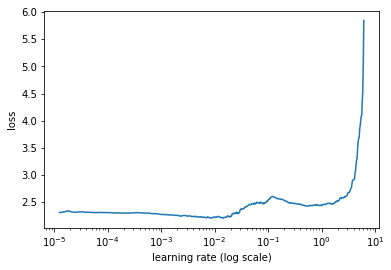

 97%|█████████▋| 605/625 [00:50<00:01, 12.10it/s, loss=8.86]

In [21]:
learner = get_learner(wrn_22(), 8)
learner.lr_find(wds=1e-4)
learner.sched.plot(n_skip_end=1)

In [8]:
learner = get_learner(wrn_22(), 8)
learner.lr_find(wds=1e-4)
learner.sched.plot(n_skip_end=1)

> /home/ubuntu/Kaukasos/research/fastai/model.py(218)validate()
-> preds, l = stepper.evaluate(VV(x), VV(y))
(Pdb) preds
*** NameError: name 'preds' is not defined
(Pdb) x.shape
*** AttributeError: 'list' object has no attribute 'shape'
(Pdb) len(x)
1
(Pdb) x
[
( 0 , 0 ,.,.) = 
  0.6301  0.6777  0.7095  ...  -0.6240 -0.7986 -1.0050
  0.4872  0.5984  0.6777  ...   0.1221  0.0904  0.0428
  0.4396  0.4079  0.4714  ...  -0.3541 -0.3382 -0.3859
           ...             ⋱             ...          
 -0.0684 -0.0525 -0.2747  ...   0.0586 -0.1477 -0.3382
 -0.0525 -0.1001 -0.1954  ...   0.0586  0.1221 -0.2271
 -0.0366 -0.0207 -0.1795  ...   0.0110 -0.0525  0.1063

( 0 , 1 ,.,.) = 
  0.3551  0.3712  0.3712  ...  -0.8367 -0.9817 -1.1588
  0.2746  0.3712  0.4195  ...  -0.1281 -0.1442 -0.1764
  0.3068  0.2585  0.3068  ...  -0.3857 -0.3535 -0.3696
           ...             ⋱             ...          
 -0.3052 -0.2891 -0.4985  ...  -0.2730 -0.4502 -0.6112
 -0.3052 -0.3374 -0.4018  ...  -0.2891 -0.2

(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(219)validate()
-> if isinstance(x,list): batch_cnts.append(len(x[0]))
(Pdb) preds
Variable containing:
1.00000e+09 *
 0.3430 -0.4839 -0.0844  ...  -0.0590  0.1992  0.1243
 0.1110 -0.1565 -0.0273  ...  -0.0191  0.0645  0.0401
 1.5416 -2.1788 -0.3765  ...  -0.2625  0.8953  0.5576
          ...             ⋱             ...          
 0.1236 -0.1740 -0.0303  ...  -0.0213  0.0716  0.0447
 1.0842 -1.5281 -0.2646  ...  -0.1856  0.6281  0.3925
 0.1488 -0.2099 -0.0363  ...  -0.0256  0.0861  0.0539
[torch.cuda.FloatTensor of size 512x10 (GPU 0)]

(Pdb) l
214  	    stepper.reset(False)
215  	    with no_grad_context():
216  	        for (*x,y) in iter(dl):
217  	            pdb.set_trace()
218  	            preds, l = stepper.evaluate(VV(x), VV(y))
219  ->	            if isinstance(x,list): batch_cnts.append(len(x[0]))
220  	            else: batch_cnts.append(len(x))
221  	            loss.append(to_np(l))
222  	            res.append([f(

TypeError: eq received an invalid combination of arguments - got (torch.LongTensor), but expected one of:
 * (int value)
      didn't match because some of the arguments have invalid types: ([31;1mtorch.LongTensor[0m)
 * (torch.cuda.LongTensor other)
      didn't match because some of the arguments have invalid types: ([31;1mtorch.LongTensor[0m)


---

## Fastai DAWN Bench submission w/ fastai dataloaders

I've been having trouble getting the pytorch dataloaders above to play nice: for some reason they won't return cuda tensors, only cpu float tensors... but the model is waiting to run on data on the gpu...

I don't want to manually build fastai dataloaders either – since in that case they require a validation split and more low-level thinking that'll distract a lot from wider issues; so I'm using the automated fastai way.

In [18]:
bs=8; sz=32; fulldata=False

In [19]:
aug_tfms   = [RandomFlip(), RandomCrop(32)] # hopefully this is the same as aug_tfms above
tfms       = tfms_from_stats(stats, sz=32, aug_tfms=aug_tfms, pad=4)

if not fulldata:
    # quick prototyping csv (10% dataset)
    val_idxs = get_cv_idxs(n=pd.read_csv(PATH/'tmp.csv').count()[0])
    model_data = ImageClassifierData.from_csv(
        PATH, 'train', PATH/'tmp.csv', bs=bs, tfms=tfms, val_idxs=val_idxs)
else:
    # full dataset
    model_data = ImageClassifierData.from_paths(
        PATH, bs=bs, tfms=tfms, trn_name='train',val_name='test')

In [34]:
learner = ConvLearner.from_model_data(wrn_22(), model_data)
learner.crit = nn.CrossEntropyLoss(); learner.metrics = [accuracy]
learner.lr_find(wds=1e-4)
learner.sched.plot(n_skip_end=1)

> /home/ubuntu/Kaukasos/research/fastai/model.py(218)validate()
-> preds, l = stepper.evaluate(VV(x), VV(y))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(219)validate()
-> if isinstance(x,list): batch_cnts.append(len(x[0]))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(221)validate()
-> loss.append(to_np(l))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(222)validate()
-> res.append([f(preds.data, y) for f in metrics])
(Pdb) type(x[0])
<class 'torch.cuda.FloatTensor'>
(Pdb) type(y)
<class 'torch.cuda.LongTensor'>
(Pdb) type(preds), type(preds.data)
(<class 'torch.autograd.variable.Variable'>, <class 'torch.cuda.FloatTensor'>)
(Pdb) torch.cuda.FloatTensor(1) == torch.cuda.LongTensor(1)
*** TypeError: eq received an invalid combination of arguments - got (torch.cuda.LongTensor), but expected one of:
 * (float value)
      didn't match because some of the arguments have invalid types: (torch.cuda.LongTensor)
 * (torch.cuda.FloatTensor other)
      didn't m

BdbQuit: 

In [20]:
learner = ConvLearner.from_model_data(wrn_22(), model_data)
learner.crit = nn.CrossEntropyLoss(); learner.metrics = [accuracy]
learner.lr_find(wds=1e-4)
learner.sched.plot(n_skip_end=1)

> /home/ubuntu/Kaukasos/research/fastai/model.py(218)validate()
-> preds, l = stepper.evaluate(VV(x), VV(y))
(Pdb) type(y)
<class 'torch.cuda.LongTensor'>
(Pdb) l
213  	    batch_cnts,loss,res = [],[],[]
214  	    stepper.reset(False)
215  	    with no_grad_context():
216  	        for (*x,y) in iter(dl):
217  	            pdb.set_trace()
218  ->	            preds, l = stepper.evaluate(VV(x), VV(y))
219  	            if isinstance(x,list): batch_cnts.append(len(x[0]))
220  	            else: batch_cnts.append(len(x))
221  	            loss.append(to_np(l))
222  	            res.append([f(preds.data, y) for f in metrics])
223  	    return [np.average(loss, 0, weights=batch_cnts)] + list(np.average(np.stack(res), 0, weights=batch_cnts))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(219)validate()
-> if isinstance(x,list): batch_cnts.append(len(x[0]))
(Pdb) type(preds), type(preds.data)
(<class 'torch.autograd.variable.Variable'>, <class 'torch.cuda.FloatTensor'>)
(Pdb) type(y)

BdbQuit: 

In [16]:
learner = ConvLearner.from_model_data(wrn_22(), model_data)
learner.crit = nn.CrossEntropyLoss(); learner.metrics = [accuracy]
learner.lr_find(wds=1e-4)
learner.sched.plot(n_skip_end=1)

> /home/ubuntu/Kaukasos/research/fastai/model.py(218)validate()
-> preds, l = stepper.evaluate(VV(x), VV(y))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(219)validate()
-> if isinstance(x,list): batch_cnts.append(len(x[0]))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(221)validate()
-> loss.append(to_np(l))
(Pdb) n
> /home/ubuntu/Kaukasos/research/fastai/model.py(222)validate()
-> res.append([f(preds.data, y) for f in metrics])
(Pdb) !f
*** NameError: name 'f' is not defined
(Pdb) metrics[0]
<function accuracy at 0x7f11e1985e18>
(Pdb) metrics[0](preds.data,y)
0.216796875
(Pdb) torch.max(preds, dim=1)[1].type()
*** TypeError: type() missing 1 required positional argument: 't'
(Pdb) torch.max(preds, dim=1)[1].shape
torch.Size([512])
(Pdb) torch.max(preds,dim=1)[1][0].type()
*** TypeError: type() missing 1 required positional argument: 't'
(Pdb) torch.max(preds,dim=1)[1]
Variable containing:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

(Pdb) type(torch.max(preds,dim=1)[1])
<class 'torch.autograd.variable.Variable'>
(Pdb) len(torch.max(preds,dim=1)[1])
512
(Pdb) torch.max(preds,dim=1)[1].__dict__
{}
(Pdb) preds.type()
*** TypeError: type() missing 1 required positional argument: 't'
(Pdb) len(preds)
512
(Pdb) preds[0]
Variable containing:
1.00000e+07 *
  4.0392
 -8.2422
  1.2356
  1.3654
 -4.5605
 -0.1626
  0.6589
  0.3052
  3.2308
  1.8972
[torch.cuda.FloatTensor of size 10 (GPU 0)]

(Pdb) preds.dtype
*** AttributeError: 'Variable' object has no attribute 'dtype'
(Pdb) preds.__attr__
*** AttributeError: 'Variable' object has no attribute '__attr__'
(Pdb) preds.__dict__
{}
(Pdb) preds.type
<bound method Variable.type of Variable containing:
 4.0392e+07 -8.2422e+07  1.2356e+07  ...   3.0517e+06  3.2308e+07  1.8972e+07
 4.1468e+07 -8.4591e+07  1.2687e+07  ...   3.1213e+06  3.3149e+07  1.9459e+07
 5.8601e+07 -1.1950e+08  1.7922e+07  ...   4.3952e+06  4.6815e+07  2.7472e+07
                ...                   ⋱         

BdbQuit: 

## scrap

In [6]:
DataLoader.__init__

<function fastai.dataloader.DataLoader.__init__(self, dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, pad_idx=0, num_workers=None, pin_memory=False, drop_last=False, pre_pad=True, half=False, transpose=False, transpose_y=False)>

In [7]:
torch.utils.data.DataLoader.__init__

<function torch.utils.data.dataloader.DataLoader.__init__(self, dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=<function default_collate at 0x7f9a854cb048>, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None)>

In [42]:
def get_loaders(bs, num_workers):
    traindir = str(PATH/'train')
    valdir   = str(PATH/'test')
    tfms     = [transforms.ToTensor(),
                transforms.Normalize(stats[0], stats[1])]
                #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
    aug_tfms = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
        ] + tfms)
    
    train_dataset = datasets.ImageFolder(traindir, aug_tfms)
    val_dataset   = datasets.ImageFolder(valdir, transforms.Compose(tfms))
    aug_dataset   = datasets.ImageFolder(valdir, aug_tfms)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=False)
    val_loader   = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=False)
    aug_loader   = torch.utils.data.DataLoader(
        aug_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=False)

    ## Want automated GPU/CPU handling so using fastai dataloaders
#     train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, 
#                               num_workers=num_workers, pin_memory=True)
#     val_loader   = DataLoader(val_dataset, batch_size=bs, shuffle=False,
#                               num_workers=num_workers, pin_memory=True)
#     aug_loader   = DataLoader(aug_dataset, batch_size=bs, shuffle=False,
#                               num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, aug_loader

In [130]:
bs=64; sz=32; num_workers=1

traindir = str(PATH/'train')
valdir   = str(PATH/'test')
tfms     = [transforms.ToTensor(),
            transforms.Normalize(stats[0], stats[1])]
            #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
aug_tfms = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
    ] + tfms)

train_dataset = datasets.ImageFolder(traindir, aug_tfms)
val_dataset   = datasets.ImageFolder(valdir, transforms.Compose(tfms))
aug_dataset   = datasets.ImageFolder(valdir, aug_tfms)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader   = torch.utils.data.DataLoader(
    val_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
aug_loader   = torch.utils.data.DataLoader(
    aug_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)

In [131]:
train_loader.cuda()

AttributeError: 'DataLoader' object has no attribute 'cuda'

---

In [132]:
x,y = next(iter(train_loader))

In [133]:
x[0].type()

'torch.FloatTensor'

In [135]:
type(y[0])

int

In [29]:
tfms = tfms_from_stats(stats, sz=32)
md   = ImageClassifierData.from_csv(PATH, 'train', PATH/'tmp.csv', tfms=tfms)

In [30]:
next(iter(md.trn_dl))[0].type()

'torch.cuda.FloatTensor'

In [33]:
md.trn_ds.

In [34]:
train_dataset.

In [13]:
train_loader,_,_ = get_loaders(bs=64, num_workers=1)

In [14]:
next(iter(train_loader))[0].type()

TypeError: batch must contain numbers, dicts or lists; found <class 'torch.FloatTensor'>

---

In [13]:
## Aside: making a small subset of the dataset for fast troubleshooting
## also bc idk how to marry pytorch dataloaders w/ csv's yet.
import cifar_utils
PATH = cifar_utils.create_cifar_subset(PATH, copydirs=['train','test'], p=0.1)

In [28]:
# df.head()

In [38]:
import cifar_utils

In [53]:
df = cifar_utils.generate_csv(PATH)
df.to_csv(PATH/'tmp.csv', index=False)

In [54]:
df = pd.read_csv(PATH/'tmp.csv', index_col=0, header=0, dtype=str)

In [56]:
fnames = df.index.values
# fnames = df.iloc[:,0].values
df.iloc[:,0] = df.iloc[:,0].str.split(' ')
fnames,csv_labels= sorted(fnames), list(df.to_dict().values())[0]

In [60]:
fnames[:10], list(csv_labels.items())[:10]

(['airplane/10243_airplane.png',
  'airplane/10267_airplane.png',
  'airplane/10297_airplane.png',
  'airplane/1039_airplane.png',
  'airplane/10493_airplane.png',
  'airplane/10681_airplane.png',
  'airplane/10741_airplane.png',
  'airplane/10798_airplane.png',
  'airplane/10989_airplane.png',
  'airplane/11002_airplane.png'],
 [('frog/5176_frog.png', ['frog']),
  ('frog/11728_frog.png', ['frog']),
  ('frog/36842_frog.png', ['frog']),
  ('frog/48940_frog.png', ['frog']),
  ('frog/24519_frog.png', ['frog']),
  ('frog/26268_frog.png', ['frog']),
  ('frog/18585_frog.png', ['frog']),
  ('frog/8564_frog.png', ['frog']),
  ('frog/11404_frog.png', ['frog']),
  ('frog/3311_frog.png', ['frog'])])

---

In [44]:
learner = get_learner(wrn_22(), 512)

In [45]:
x,y = next(iter(learner.data.trn_dl))

In [46]:
type(x[0]), type(y[0])

(torch.FloatTensor, int)

---

In [21]:
next(iter(learner.data.val_dl))[0].type(), next(iter(learner.data.trn_dl))[0].type()

('torch.FloatTensor', 'torch.FloatTensor')

---

In [23]:
tfms = tfms_from_stats(stats, sz=32)
md   = ImageClassifierData.from_csv(PATH, 'train', PATH/'tmp.csv', tfms=tfms)

In [26]:
next(iter(md.trn_dl))[0].type()

'torch.cuda.FloatTensor'

In [47]:
learner = get_learner(wrn_22(), 512)
learner.lr_find(wds=1e-4)
learner.sched.plot(n_skip_end=1)

TypeError: eq received an invalid combination of arguments - got (torch.LongTensor), but expected one of:
 * (int value)
      didn't match because some of the arguments have invalid types: ([31;1mtorch.LongTensor[0m)
 * (torch.cuda.LongTensor other)
      didn't match because some of the arguments have invalid types: ([31;1mtorch.LongTensor[0m)


---
```
TypeError: eq received an invalid combination of arguments - got (torch.LongTensor), but expected one of:
 * (int value)
      didn't match because some of the arguments have invalid types: (torch.LongTensor)
 * (torch.cuda.LongTensor other)
      didn't match because some of the arguments have invalid types: (torch.LongTensor)
```

In [ ]:
learner = get_learner(wrn_22(), 512)
learner.lr_find(wds=1e-4)
learner.sched.plot(n_skip_end=1)